In [15]:
# CELL 1 - Import Libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

In [16]:
# CELL 2 - Load data

# Define the local file paths
# windows
# data_dir = "C:\\Users\\YourName\\Documents\\Data\\"   # Change to your actual path

# Linux/Mac
data_dir = "D:/Winter Semester 2024_25/Neidi/Data_Science_challenge/"  # Change to your actual path

weather_data = pd.read_excel(data_dir + 'Weather_Data_2015_2024-to dec 7 -11PM.xlsx')
generation_data = pd.read_excel(data_dir + 'Actual Generation 2015-2024-to dec 7 -11PM.xlsx')
consumption_data = pd.read_excel(data_dir + 'Actual Consumption 2015-2024-to dec 7 -11PM.xlsx')
price_data = pd.read_excel(data_dir + 'Price_2015_2024-to dec 7 -11__ADDED MISSING PRICES PM.xlsx')


In [17]:
# CELL 3 - Data Pre-processing

# Convert timestamps to datetime format
generation_data['Start date'] = pd.to_datetime(generation_data['Start date'])
price_data['Start date'] = pd.to_datetime(price_data['Start date'])
consumption_data['Start date'] = pd.to_datetime(consumption_data['Start date'])

weather_data['Start date'] = weather_data['Start date'].str.replace(' +0000 UTC', '')
weather_data['Start date'] = pd.to_datetime(weather_data['Start date'])


# Set datetime index for resampling
weather_data.set_index('Start date', inplace=True)

# Separate numeric and non-numeric columns
numeric_cols = weather_data.select_dtypes(include=['float64', 'int64'])
non_numeric_cols = weather_data.select_dtypes(exclude=['float64', 'int64'])

# Resample numeric data
numeric_resampled = numeric_cols.resample('h').mean()
non_numeric_resampled = non_numeric_cols.resample('h').ffill()

# Combine them back
weather_data = pd.concat([numeric_resampled, non_numeric_resampled], axis=1).reset_index()

# Drop unnecessary columns
countries_to_drop = [col for col in price_data.columns if '€/MWh' in col and 'Germany/Luxembourg' not in col]
weather_columns_to_drop = ['sea_level', 'grnd_level', 'timezone', 'city_name', 'lat', 'lon','weather_id','weather_icon','weather_main',
                           'weather_description','rain_1h','rain_3h','dt']
generation_data.drop(columns=['End date'], inplace=True, errors='ignore')
consumption_data.drop(columns=['End date'], inplace=True, errors='ignore')
price_data.drop(columns=countries_to_drop+['End date'], inplace=True, errors='ignore')
weather_data.drop(columns=weather_columns_to_drop, inplace=True, errors='ignore')

C:\Users\USER\AppData\Local\Temp\ipykernel_10732\984660121.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  generation_data['Start date'] = pd.to_datetime(generation_data['Start date'])
C:\Users\USER\AppData\Local\Temp\ipykernel_10732\984660121.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_data['Start date'] = pd.to_datetime(price_data['Start date'])
C:\Users\USER\AppData\Local\Temp\ipykernel_10732\984660121.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  consumption_data['Start date'] = pd.to_datetime(consumption_data['Start date'])


In [18]:
# CELL 4 - Merge all data

# Merge datasets based on timestamp
merged_data = generation_data.merge(price_data, on='Start date', how='inner')
merged_data = merged_data.merge(consumption_data, on='Start date', how='inner')
merged_data = merged_data.merge(weather_data, left_on='Start date', right_on='Start date', how='left')

# Handle missing data
merged_data.dropna(axis=1, how='all', inplace=True)
merged_data.fillna(method='ffill', inplace=True)

# Replace invalid strings with NaN and forward fill
merged_data.replace('-', np.nan, inplace=True)
merged_data.fillna(method='ffill', inplace=True)

# Save merged data
merged_file_path = 'D:/Winter Semester 2024_25/Neidi/Data_Science_challenge/cleaned_merged_data.xlsx'
merged_data.to_excel(merged_file_path, index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_10732\2623005360.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_10732\2623005360.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data.replace('-', np.nan, inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_10732\2623005360.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [19]:
# CELL 5 - Feuture Engineering and Process Data for Training

# Load cleaned data for training
merged_data = merged_data[merged_data['Start date'] <= '2024-12-07']  # Filter data until 7th Dec 2024
merged_data = pd.read_excel(merged_file_path)

# Split the data into features and target
X = merged_data.drop(columns=['Germany/Luxembourg [€/MWh]'])  # Features
y = merged_data['Germany/Luxembourg [€/MWh]']  # Target variable

# Train-Test Split
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Feature Engineering - Add Lag Features and Rolling Averages
for lag in [24, 48, 72]:  # Lag for 1 day, 2 days, 3 days
    X_train[f'price_lag_{lag}'] = y_train.shift(lag)
    X_test[f'price_lag_{lag}'] = y_test.shift(lag)

for window in [24, 48, 72]:  # Rolling averages for 1, 2, and 3 days
    X_train[f'temp_roll_{window}'] = X_train['temp'].rolling(window=window, min_periods=1).mean()
    X_test[f'temp_roll_{window}'] = X_test['temp'].rolling(window=window, min_periods=1).mean()

# Fill NaN values from lagging
X_train = X_train.fillna(method='bfill')
X_test = X_test.fillna(method='bfill')

# Fill NaN in rolling and interaction features
X_train = X_train.ffill().bfill().fillna(0)
X_test = X_test.ffill().bfill().fillna(0)

# Fill NaN values in y_train with mean to retain dataset size
y_train = y_train.fillna(y_train.mean())
y_train = y_train.dropna()


# Reset index to avoid alignment issues
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Ensure Consistent Sizes
X_train = X_train.loc[y_train.index]
X_test = X_test.loc[y_test.index]

# Ensure feature names are strings and sanitize them
X_train.columns = X_train.columns.map(str).str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.map(str).str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)


# Rename y_train and y_test to avoid special characters in target name
y_train.name = 'Germany_Luxembourg_EUR_MWh'
y_test.name = 'Germany_Luxembourg_EUR_MWh'


C:\Users\USER\AppData\Local\Temp\ipykernel_10732\3722275148.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'price_lag_{lag}'] = y_train.shift(lag)
C:\Users\USER\AppData\Local\Temp\ipykernel_10732\3722275148.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[f'price_lag_{lag}'] = y_test.shift(lag)
C:\Users\USER\AppData\Local\Temp\ipykernel_10732\3722275148.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [21]:
# CELL 6 - Train the model

# Train XGBoost model with tuned hyperparameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,  # Reduced to prevent overfitting
    learning_rate=0.05,
    max_depth=6,  # Lowered to reduce complexity
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    # early_stopping_rounds=7,  # Reduced for earlier stopping
    # reg_lambda=2.0,  # L2 regularization
    # reg_alpha=1.5  # L1 regularization
)

# Drop invalid columns or convert them to numeric
for col in ['Start_date', 'End_date_x', 'End_date_y', 'End_date', 'dt_iso']:
    if col in X_train.columns:
        X_train[col] = pd.to_datetime(X_train[col], errors='coerce').astype(np.int64) // 10**9
        X_test[col] = pd.to_datetime(X_test[col], errors='coerce').astype(np.int64) // 10**9

for col in ['weather_main', 'weather_description', 'weather_icon']:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

# Handle sklearn_tags error
try:
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=10
    )
except AttributeError as e:
    if '__sklearn_tags__' in str(e):
        print("Ignoring sklearn_tags error and proceeding with training.")
    else:
        raise e

[0]	validation_0-rmse:45.19445
[10]	validation_0-rmse:32.43009
[20]	validation_0-rmse:27.42538
[30]	validation_0-rmse:26.60624
[40]	validation_0-rmse:26.63132
[50]	validation_0-rmse:26.96315
[60]	validation_0-rmse:27.38420
[70]	validation_0-rmse:27.45075
[80]	validation_0-rmse:27.82817
[90]	validation_0-rmse:27.92480
[100]	validation_0-rmse:28.11970
[110]	validation_0-rmse:28.50332
[120]	validation_0-rmse:28.80287
[130]	validation_0-rmse:28.81332
[140]	validation_0-rmse:28.96154
[150]	validation_0-rmse:29.04463
[160]	validation_0-rmse:29.35667
[170]	validation_0-rmse:29.74576
[180]	validation_0-rmse:29.84744
[190]	validation_0-rmse:29.80967
[200]	validation_0-rmse:29.93309
[210]	validation_0-rmse:30.05826
[220]	validation_0-rmse:30.00858
[230]	validation_0-rmse:30.04722
[240]	validation_0-rmse:30.12982
[250]	validation_0-rmse:30.14678
[260]	validation_0-rmse:30.33619
[270]	validation_0-rmse:30.44600
[280]	validation_0-rmse:30.51146
[290]	validation_0-rmse:30.50324
[299]	validation_0-rm

In [22]:
# CELL - 7 Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 23.23717245562297
Mean Squared Error (MSE): 932.7194386260811
Root Mean Squared Error (RMSE): 30.540455769783154
R-squared (R2): 0.5761879379700401


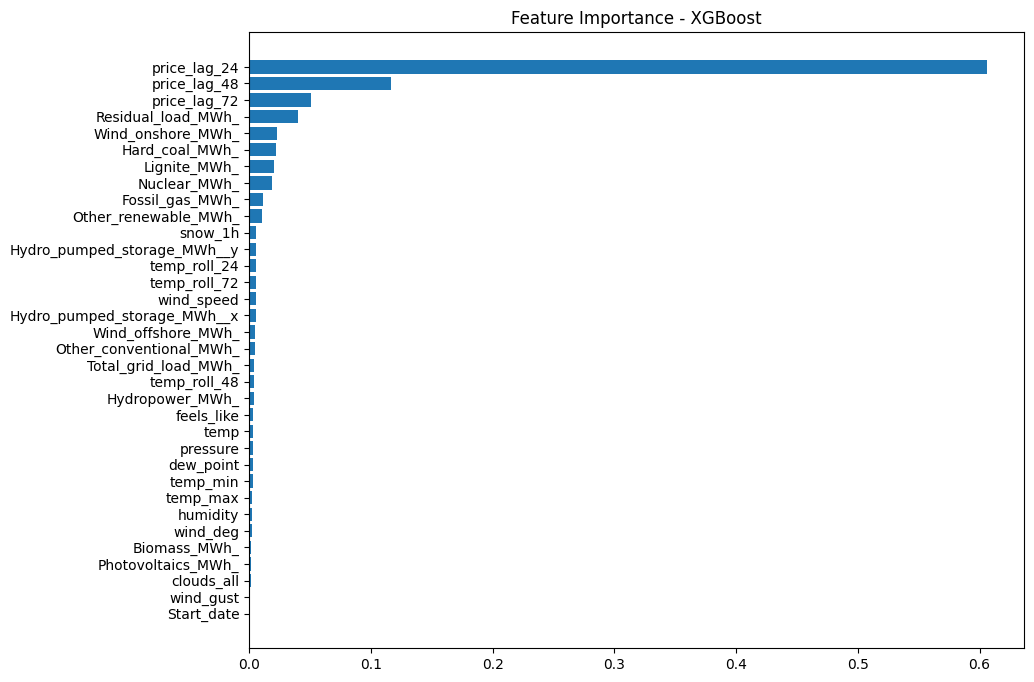

In [23]:
# CELL - 8 Feature Importance
feature_importances = xgb_model.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, 8))
plt.barh(X_train.columns[sorted_idx], feature_importances[sorted_idx])
plt.title("Feature Importance - XGBoost")
plt.show()

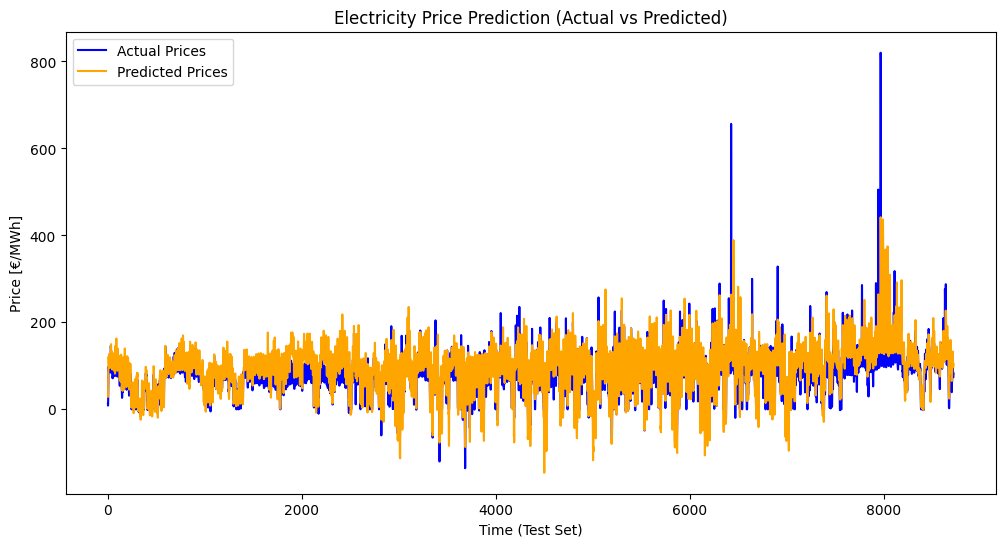

In [24]:
# Visualize Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='orange')
plt.title('Electricity Price Prediction (Actual vs Predicted)')
plt.xlabel('Time (Test Set)')
plt.ylabel('Price [€/MWh]')
plt.legend()
plt.show()


<Figure size 1200x600 with 0 Axes>

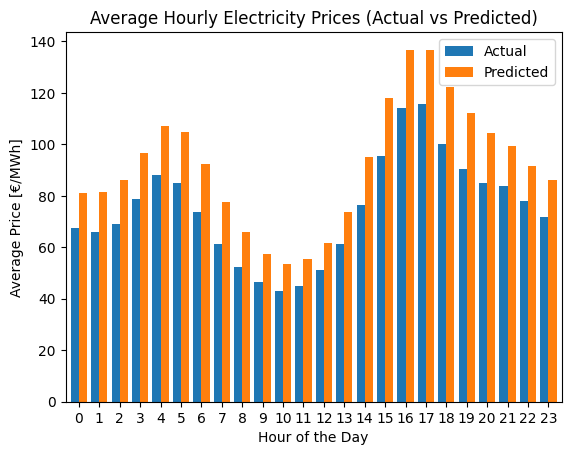

In [25]:
import pandas as pd

# Create a DataFrame to aggregate by hour
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
hourly_avg = results_df.groupby(results_df.index % 24).mean()

plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar', width=0.8)
plt.title('Average Hourly Electricity Prices (Actual vs Predicted)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Price [€/MWh]')
plt.xticks(rotation=0)
plt.show()


In [27]:
# CELL 9 - Predict the day ahead price

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your manually created features Excel file
manual_features_path = 'D:/Winter Semester 2024_25/Neidi/Data_Science_challenge/Manual_Features.xlsx'
manual_features_df = pd.read_excel(manual_features_path)

# Ensure Start_date is converted to datetime
manual_features_df['Start_date'] = pd.to_datetime(manual_features_df['Start_date'])

# Add time-based features
manual_features_df['hour'] = manual_features_df['Start_date'].dt.hour
manual_features_df['day_of_week'] = manual_features_df['Start_date'].dt.dayofweek
manual_features_df['month'] = manual_features_df['Start_date'].dt.month

# Convert Start_date to Unix timestamp
manual_features_df['Start_date'] = manual_features_df['Start_date'].astype(np.int64) // 10**9

# Reset the index of merged_data to ensure 'Start date' column is available
if 'Start date' in merged_data.index.names:
    merged_data = merged_data.reset_index()

# Ensure 'Start date' is converted to datetime and set as the index in merged_data
if 'Start date' in merged_data.columns:
    merged_data['Start date'] = pd.to_datetime(merged_data['Start date'], errors='coerce')
    merged_data.set_index('Start date', inplace=True)
    print("'Start date' column set as DatetimeIndex.")
else:
    raise ValueError("'Start date' column not found in merged_data.")


# Handle price lag features dynamically based on available data
last_known_prices = merged_data['Germany/Luxembourg [€/MWh]'].iloc[-72:]
num_predictions = len(manual_features_df)

if len(last_known_prices) >= 24:
    manual_features_df['price_lag_24'] = (last_known_prices.iloc[-24:].values.tolist() * ((num_predictions + 23) // 24))[:num_predictions]
else:
    manual_features_df['price_lag_24'] = last_known_prices.values.tolist() * ((num_predictions + len(last_known_prices) - 1) // len(last_known_prices))
    manual_features_df['price_lag_24'] = manual_features_df['price_lag_24'][:num_predictions]

if len(last_known_prices) >= 48:
    manual_features_df['price_lag_48'] = (last_known_prices.iloc[-48:-24].values.tolist() * ((num_predictions + 23) // 24))[:num_predictions]
else:
    manual_features_df['price_lag_48'] = (last_known_prices.iloc[-min(48, len(last_known_prices)):].values.tolist() * ((num_predictions + 23) // min(48, len(last_known_prices))))[:num_predictions]

if len(last_known_prices) >= 72:
    manual_features_df['price_lag_72'] = (last_known_prices.iloc[-72:-48].values.tolist() * ((num_predictions + 23) // 24))[:num_predictions]
else:
    manual_features_df['price_lag_72'] = (last_known_prices.iloc[-min(72, len(last_known_prices)):].values.tolist() * ((num_predictions + 23) // min(72, len(last_known_prices))))[:num_predictions]


# Calculate rolling temperature features (assuming you have a way to estimate future temperatures)
# Here we use historical averages for simplicity
if 'temp' in merged_data.columns:
    # Ensure temp column exists in merged_data
    historical_temperatures = merged_data['temp'].resample('D').mean().iloc[-72:]
    if 'temp' in manual_features_df.columns:
        manual_features_df['temp'] = historical_temperatures.iloc[-1].repeat(len(manual_features_df))

    for window in [24, 48, 72]:
        if 'temp' in manual_features_df.columns:
            manual_features_df[f'temp_roll_{window}'] = manual_features_df['temp'].rolling(window=window, min_periods=1).mean()
else:
    print("Temperature data ('temp') not found in merged_data. Skipping temperature-related features.")

# Drop columns from X_train that are not in manual_features_df
columns_to_keep = [col for col in X_train.columns if col in manual_features_df.columns or col in ['hour', 'day_of_week', 'month']]
X_train_filtered = X_train[columns_to_keep]

# Ensure columns match between manual_features_df and X_train_filtered
manual_features_df = manual_features_df[X_train_filtered.columns]

# Make predictions iteratively to handle dependencies between hours
predictions = []
for i in range(len(manual_features_df)):
    row = manual_features_df.iloc[[i]]

    # Fill missing numerical features with mean or median values
    for col in row.columns:
        if row[col].isnull().any():
            if pd.api.types.is_numeric_dtype(X_train_filtered[col]):
                row[col] = X_train_filtered[col].median()
            else:
                row[col] = X_train_filtered[col].mode()[0]

    pred = xgb_model.predict(row)[0]
    predictions.append(pred)

    # Update lag features for the next iteration
    if i >= 24:
        manual_features_df.at[manual_features_df.index[i], 'price_lag_24'] = predictions[i-24]
    if i >= 48:
        manual_features_df.at[manual_features_df.index[i], 'price_lag_48'] = predictions[i-48]
    if i >= 72:
        manual_features_df.at[manual_features_df.index[i], 'price_lag_72'] = predictions[i-72]

# Create results DataFrame
prediction_hours = pd.date_range(datetime(2025, 2, 18), datetime(2025, 2, 18) + timedelta(hours=23), freq='h')
results_df = pd.DataFrame({
    'Datetime': prediction_hours,
    'Hour': prediction_hours.hour,
    'Predicted_Price_EUR_MWh': np.round(predictions, 2)
})

# Print predictions
print("\nPredicted Prices for January 29, 2025:")
print(results_df.to_string(index=False))

'Start date' column set as DatetimeIndex.

Predicted Prices for January 29, 2025:
           Datetime  Hour  Predicted_Price_EUR_MWh
2025-02-18 00:00:00     0               148.960007
2025-02-18 01:00:00     1               138.229996
2025-02-18 02:00:00     2               122.440002
2025-02-18 03:00:00     3               122.980003
2025-02-18 04:00:00     4               125.260002
2025-02-18 05:00:00     5               121.339996
2025-02-18 06:00:00     6               137.440002
2025-02-18 07:00:00     7               159.309998
2025-02-18 08:00:00     8               152.559998
2025-02-18 09:00:00     9               131.800003
2025-02-18 10:00:00    10               111.459999
2025-02-18 11:00:00    11               103.760002
2025-02-18 12:00:00    12                98.669998
2025-02-18 13:00:00    13               107.029999
2025-02-18 14:00:00    14               115.379997
2025-02-18 15:00:00    15               130.529999
2025-02-18 16:00:00    16               167.490005


In [28]:
# CELL 10 - Save predicted price in CSV file

# Define the file path for saving
csv_filename = "D:/Winter Semester 2024_25/Neidi/Data_Science_challenge/Predicted_Prices_Feb_18_2025.csv"

# Save the DataFrame as a CSV file
results_df.to_csv(csv_filename, index=False)

print(f"Predicted results saved successfully as {csv_filename}")


Predicted results saved successfully as D:/Winter Semester 2024_25/Neidi/Data_Science_challenge/Predicted_Prices_Feb_18_2025.csv
